<a href="https://colab.research.google.com/github/staerkjoe/AdvNLP_miniproject/blob/main/NLP_MiniProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch torchvision transformers ftfy regex tqdm
!pip install accelerate
!pip install pytorch-pretrained-biggan

## CLIP - Load and Test

In [3]:
from transformers import CLIPProcessor, CLIPModel

# Load pretrained CLIP (text + image encoders)
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

device = "cuda"
clip_model = clip_model.to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [4]:
from PIL import Image

text = ["a red apple", "a blue car"]
image = [Image.open("/content/drive/MyDrive/Colab Notebooks/NLP/MiniProject/Sample Pictures/redapple.jpg"), Image.open("/content/drive/MyDrive/Colab Notebooks/NLP/MiniProject/Sample Pictures/airplane.jpg")]

inputs = clip_processor(text=text, images=image, return_tensors="pt", padding=True).to(device)
outputs = clip_model(**inputs)
similarity = outputs.logits_per_text.softmax(dim=-1)


In [5]:
print(similarity)

tensor([[1.0000e+00, 5.9555e-08],
        [2.3025e-01, 7.6975e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


## GAN - Load and Test

In [6]:
from pytorch_pretrained_biggan import BigGAN, truncated_noise_sample
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load pretrained model
biggan = BigGAN.from_pretrained('biggan-deep-128').to(device)
biggan.eval()


100%|██████████| 630/630 [00:00<00:00, 1789039.62B/s]


BigGAN(
  (embeddings): Linear(in_features=1000, out_features=128, bias=False)
  (generator): Generator(
    (gen_z): Linear(in_features=256, out_features=32768, bias=True)
    (layers): ModuleList(
      (0-2): 3 x GenBlock(
        (bn_0): BigGANBatchNorm(
          (scale): Linear(in_features=256, out_features=2048, bias=False)
          (offset): Linear(in_features=256, out_features=2048, bias=False)
        )
        (conv_0): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1))
        (bn_1): BigGANBatchNorm(
          (scale): Linear(in_features=256, out_features=512, bias=False)
          (offset): Linear(in_features=256, out_features=512, bias=False)
        )
        (conv_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn_2): BigGANBatchNorm(
          (scale): Linear(in_features=256, out_features=512, bias=False)
          (offset): Linear(in_features=256, out_features=512, bias=False)
        )
        (conv_2): Conv2d(512, 512, kernel_siz

In [7]:
# BigGAN takes: noise (z), class vector (one-hot), truncation
z = torch.randn(1, 128, device=device)        # latent noise
class_vector = torch.zeros(1, 1000, device=device)  # "generic" input
truncation = 0.4

with torch.no_grad():
    output = biggan(z, class_vector, truncation)


In [8]:
from torchvision.utils import save_image
save_image((output + 1) / 2, "/content/drive/MyDrive/Colab Notebooks/NLP/MiniProject/Sample Pictures/GANgenerated.jpg")  # normalize to [0,1]


## optimizing one latent vector z per text prompt

In [9]:
def generate_image(z, truncation=0.4):
    class_vector = torch.zeros(1, 1000).to(device)  # generic class
    with torch.no_grad():
        out = biggan(z, class_vector, truncation)
    return (out + 1) / 2  # scale from [-1,1] → [0,1]

In [10]:
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm

def optimize_latent_for(prompt, steps=300, lr=0.07, truncation=0.4, seed=None):
    if seed: torch.manual_seed(seed)

    # Encode text prompt once
    text_tokens = clip_processor(text=[prompt], return_tensors="pt").to(device)
    with torch.no_grad():
        text_features = clip_model.get_text_features(**text_tokens).detach().clone()

    # Initialize random latent vector z
    z = torch.randn(1, 128, device=device, requires_grad=True)
    optimizer = torch.optim.Adam([z], lr=lr)

    # Optimization loop
    pbar = tqdm(range(steps), desc=f"Optimizing for: '{prompt}'")
    for step in pbar:
        optimizer.zero_grad()
        img = biggan(z, torch.zeros(1, 1000).to(device), truncation)
        img_norm = (img + 1) / 2

        # Resize to CLIP expected input
        img_pil = torch.clamp(img_norm, 0, 1)
        img_clip = torch.nn.functional.interpolate(img_pil, size=(224,224), mode='bilinear')

        # Preprocess the image for CLIP
        img_processed = clip_processor(images=img_clip, return_tensors="pt").to(device)

        img_features = clip_model.get_image_features(**img_processed)
        loss = 1 - F.cosine_similarity(img_features, text_features).mean()

        loss.backward()
        optimizer.step()
        pbar.set_postfix({"loss": loss.item()})

    final_img = generate_image(z, truncation)
    return final_img.detach()

In [11]:
prompts = [
    "a red apple on a table",
    "a blue car in the snow",
    "a yellow bird on a branch",
]

for text in prompts:
    result = optimize_latent_for(text, steps=250)
    filename = f"{text.replace(' ', '_')}.png"
    save_image(result, filename)
    print(f"Saved: {filename}")


Optimizing for: 'a red apple on a table': 100%|██████████| 250/250 [00:42<00:00,  5.91it/s, loss=0.783]


Saved: a_red_apple_on_a_table.png


Optimizing for: 'a blue car in the snow': 100%|██████████| 250/250 [00:20<00:00, 12.32it/s, loss=0.808]


Saved: a_blue_car_in_the_snow.png


Optimizing for: 'a yellow bird on a branch': 100%|██████████| 250/250 [00:51<00:00,  4.86it/s, loss=0.775]


Saved: a_yellow_bird_on_a_branch.png


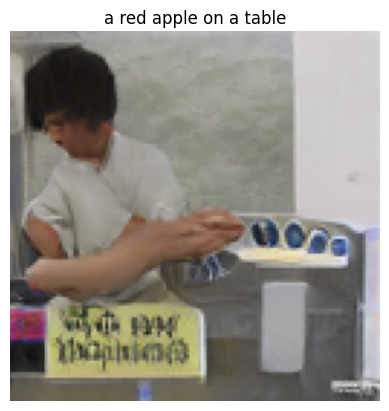

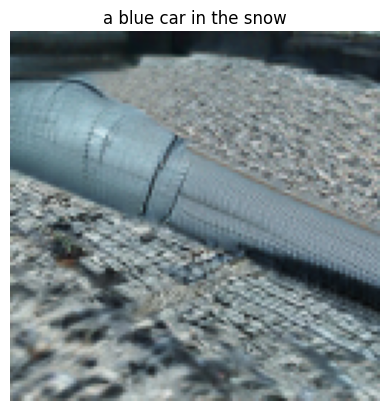

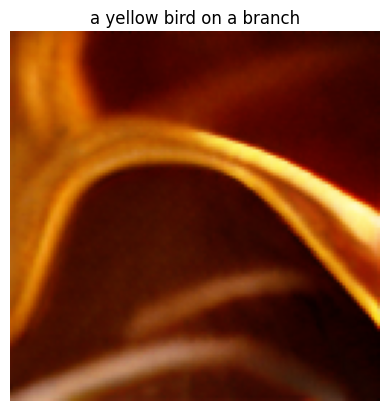

In [12]:
import matplotlib.pyplot as plt
from torchvision.io import read_image

for text in prompts:
    img = read_image(f"{text.replace(' ', '_')}.png").permute(1,2,0)
    plt.imshow(img.cpu())
    plt.title(text)
    plt.axis('off')
    plt.show()
